# **Foods Recognition**
In this notebook we will build tensorflow model to recognize foods. We will use **Tensorflow Object Detection API** and **MobileNet v2**.

Here is step by step building foods recogntion model.

# Import Libraries

In [ ]:
import os
import shutil
import zipfile
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import time
from google.colab import files
from tensorflow.keras.preprocessing import image

## Data preprocessing

### Data download

We use our custom dataset containing images of 38 types of foods. Download and extract a zip file containing the images.

In [ ]:
!gdown 1sPQaEcHxLozMJYSvfjNE5tSvNgYlmjGT

In [ ]:
# Unzip the dataset
local_zip = './foods-38.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('.')
zip_ref.close()

### Dividing data into train and validation

We devide the downloaded data into `train` and `validation` set. First we need to specify and make all directories.

In [ ]:
# Assign training and validation set directories
foods = os.listdir('images')
base_dir = 'dataset'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

# Directory with training pictures
train_dirs = [os.path.join(train_dir, str(food)) for food in foods]

# Directory with validation pictures
valid_dirs = [os.path.join(validation_dir, str(food)) for food in foods]

# Directory with test pictures
test_dirs = [os.path.join(test_dir, str(food)) for food in foods]

In [ ]:
for dir in train_dirs+valid_dirs+test_dirs:
    try:
        os.makedirs(dir)
    except:
        pass

In [ ]:
def split_data(source, train, valid, test, split=[80,15,5]):
    """Split dataset into train, valid, and test."""
    files = os.listdir(source)
    # files = random.sample(files, len(files))
    train_num = int((split[0]/sum(split))*len(files))
    valid_num = int((split[1]/sum(split))*len(files))
    
    for file in files:
        if len(os.listdir(train)) < train_num:
            shutil.copy(os.path.join(source, file), train)
        elif len(os.listdir(valid)) < valid_num:
            shutil.copy(os.path.join(source, file), valid)
        else:
            shutil.copy(os.path.join(source, file), test)

In [ ]:
for i, food in enumerate(foods):
    split_data(f'images/{food}/', 
               train_dirs[i], valid_dirs[i], test_dirs[i], 
               split=[80,15,5])

Then we create a `tf.data.Dataset` object for training and validation using the `tf.keras.utils.image_dataset_from_directory` utility.

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 5894 files belonging to 38 classes.


In [2]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                           shuffle=True,
                                                           batch_size=BATCH_SIZE,
                                                           image_size=IMG_SIZE)

Found 1121 files belonging to 38 classes.
Found 373 files belonging to 38 classes.


Show the first 16 images and labels from the training set:

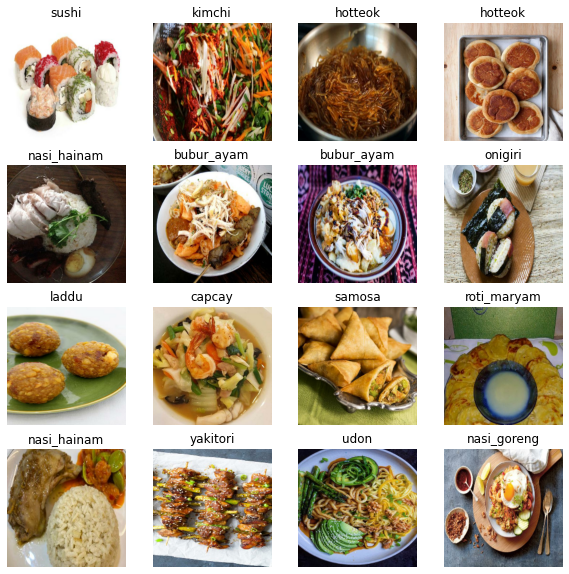

In [ ]:
class_names = train_dataset.class_names
n_class = len(class_names)

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Configure the dataset for performance

Use buffered prefetching to load images from disk without having I/O become blocking. More about this method see the [data performance](https://www.tensorflow.org/guide/data_performance) guide.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Use data augmentation

Because we don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and flipping. This helps expose the model to different aspects of the training data and reduce [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip(),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.2),
  tf.keras.layers.RandomCrop(224, 224),
  # tf.keras.layers.RandomContrast(0.2)
])

Note: These layers are active only during training, when we call `Model.fit`. They are inactive when the model is used in inference mode in `Model.evaluate` or `Model.fit`.

Let's repeatedly apply these layers to the same image and see the result.

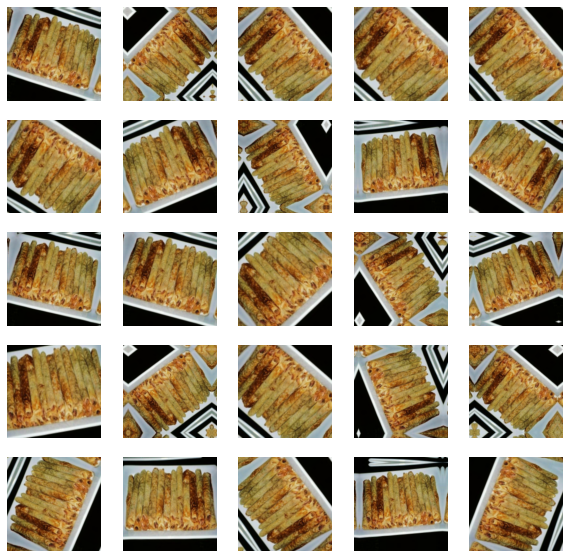

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Rescale pixel values

Next we download `tf.keras.applications.MobileNetV2` for use as our base model. This model expects pixel values in `[-1, 1]`, but at this point, the pixel values in our images are in `[0, 255]`. To rescale them, use the preprocessing method included with the model.

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

Note: Alternatively, we could rescale pixel values from `[0, 255]` to `[-1, 1]` using `tf.keras.layers.Rescaling`.

In [ ]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

Note: If using other `tf.keras.applications`, be sure to check the API doc to determine if they expect pixels in `[-1, 1]` or `[0, 1]`, or use the included `preprocess_input` function.

## Create the base model from the pre-trained convnets
We create the base model from the **MobileNet V2** model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like `jackfruit` and `syringe`. This base of knowledge will help us classify foods from our specific dataset.

First, we instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the **include_top=False** argument, we load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9420800/9406464 [==============================] - 0s 0us/step


This feature extractor converts each `224x224x3` image into a `7x7x1280` block of features. Let's see what it does to an example batch of images:

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


## Feature extraction
In this step, we will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, we add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base

It is important to freeze the convolutional base before we compile and train the model. Freezing (by setting `layer.trainable = False`) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's `trainable` flag to False will freeze all of them.

In [ ]:
base_model.trainable = False

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

### Add a classification head

To generate predictions from the block of features, average over the spatial `7x7` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single 1280-element vector per image.

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Apply a `tf.keras.layers.Dense` layer to convert these features into multiple probability prediction per image. We use `softmax` activation function to predict probaility of each classes.

In [ ]:
prediction_layer = tf.keras.layers.Dense(n_class, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 38)


Build a model by chaining together the data augmentation, rescaling, `base_model` and feature extractor layers using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional). As previously mentioned, use `training=False` as our model contains a `BatchNormalization` layer.

In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
# x = tf.keras.layers.Reshape((1280,))(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compile the model

Compile the model before training it. Since there are 38 classes, use the `tf.keras.losses.SparseCategoricalCrossentropy` loss.

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                             

The 2.2 million parameters in MobileNet are frozen, but there are 48.6 thousand _trainable_ parameters in the Dense layer. These are divided between two `tf.Variable` objects, the weights and biases.

In [ ]:
len(model.trainable_variables)

2

### Train the model

In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

36/36 [==============================] - 5s 64ms/step - loss: 4.0223 - accuracy: 0.0271


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 4.02
initial accuracy: 0.03


In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
185/185 [==============================] - 18s 75ms/step - loss: 3.6670 - accuracy: 0.0658 - val_loss: 3.2151 - val_accuracy: 0.1480
Epoch 2/10
185/185 [==============================] - 14s 74ms/step - loss: 3.0656 - accuracy: 0.1787 - val_loss: 2.7181 - val_accuracy: 0.2968
Epoch 3/10
185/185 [==============================] - 15s 78ms/step - loss: 2.6441 - accuracy: 0.2961 - val_loss: 2.3780 - val_accuracy: 0.4002
Epoch 4/10
185/185 [==============================] - 14s 75ms/step - loss: 2.3458 - accuracy: 0.3884 - val_loss: 2.1021 - val_accuracy: 0.4764
Epoch 5/10
185/185 [==============================] - 14s 73ms/step - loss: 2.1120 - accuracy: 0.4423 - val_loss: 1.9126 - val_accuracy: 0.5193
Epoch 6/10
185/185 [==============================] - 14s 74ms/step - loss: 1.9532 - accuracy: 0.4857 - val_loss: 1.7963 - val_accuracy: 0.5438
Epoch 7/10
185/185 [==============================] - 14s 75ms/step - loss: 1.7949 - accuracy: 0.5331 - val_loss: 1.6848 - val_accuracy:

### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNetV2 base model as a fixed feature extractor.

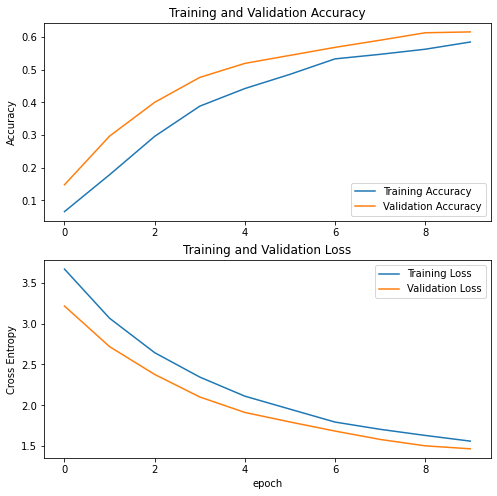

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine tuning
In the feature extraction experiment, we were only training a few layers on top of an MobileNetV2 base model. The weights of the pre-trained network were **not** updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier we added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

### Un-freeze the top layers of the model


All we need to do is unfreeze the `base_model` and set the bottom layers to be un-trainable. Then, we recompile the model (necessary for these changes to take effect), and resume training.

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


### Compile the model

As we are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, our model could overfit very quickly.

In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                             

In [ ]:
len(model.trainable_variables)

56

### Continue training the model

If we trained to convergence earlier, this step will improve our accuracy by a few percentage points.

In [ ]:
checkpoint_filepath = 'cp/checkpoints'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
fine_tune_epochs = 140
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset,
                         callbacks=[model_checkpoint_callback])

Epoch 10/150
185/185 [==============================] - 47s 221ms/step - loss: 1.3246 - accuracy: 0.6132 - val_loss: 1.1763 - val_accuracy: 0.6629
Epoch 11/150
185/185 [==============================] - 37s 196ms/step - loss: 1.2048 - accuracy: 0.6488 - val_loss: 1.0870 - val_accuracy: 0.6821
Epoch 12/150
185/185 [==============================] - 38s 201ms/step - loss: 1.1259 - accuracy: 0.6642 - val_loss: 1.0662 - val_accuracy: 0.6909
Epoch 13/150
185/185 [==============================] - 36s 195ms/step - loss: 1.0643 - accuracy: 0.6895 - val_loss: 0.9799 - val_accuracy: 0.7163
Epoch 14/150
185/185 [==============================] - 17s 90ms/step - loss: 1.0072 - accuracy: 0.6970 - val_loss: 0.9923 - val_accuracy: 0.7084
Epoch 15/150
185/185 [==============================] - 37s 199ms/step - loss: 0.9565 - accuracy: 0.7145 - val_loss: 0.9238 - val_accuracy: 0.7277
Epoch 16/150
185/185 [==============================] - 37s 198ms/step - loss: 0.9143 - accuracy: 0.7357 - val_loss: 0.

Let's take a look at the learning curves of the training and validation accuracy/loss when fine-tuning the last few layers of the MobileNetV2 base model and training the classifier on top of it.

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

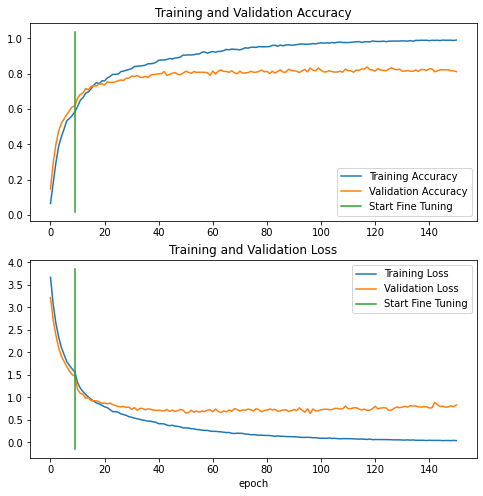

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
# plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
# plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Evaluation and prediction

Finaly we can verify the performance of the model on new data using test set.

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

11/11 [==============================] - 1s 58ms/step - loss: 0.8839 - accuracy: 0.8182
Test accuracy : 0.8181818127632141


Saving rendang.jpg to rendang.jpg

----------------------------
Predicted as `rendang` (id=24)
Confidence: 100.00%



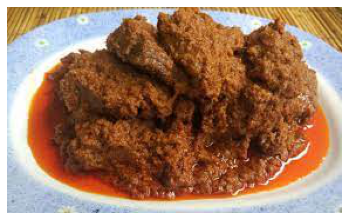

In [ ]:
uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(224, 224))
  x1 = image.img_to_array(img)
  x = np.expand_dims(x1, axis=0)

  images = np.vstack([x])
  classes = model.predict(images).argmax(axis=1)
  probs = model.predict(images).max(axis=1)
  
  plot = matplotlib.image.imread(path)
  plt.imshow(plot)
  plt.axis('off')
  plt.show

  print('\n----------------------------')
  print(f'Predicted as `{class_names[classes[0]]}` (id={classes[0]})')
  print(f'Confidence: {probs[0]*100:.2f}%\n')

## Saving the model

Now we are going to save trained model into `SavedModel` format.

In [ ]:
ts = int(time.time())
file_path = f"./tf-models/"
model.save(filepath=file_path, save_format='tf')
saved = f'./tf-models-{ts}.zip'

INFO:tensorflow:Assets written to: ./tf-models/assets


In [ ]:
!zip -r $saved $checkpoint_filepath
files.download(saved)

  adding: cp/checkpoints/ (stored 0%)
  adding: cp/checkpoints/saved_model.pb (deflated 91%)
  adding: cp/checkpoints/keras_metadata.pb (deflated 96%)
  adding: cp/checkpoints/assets/ (stored 0%)
  adding: cp/checkpoints/variables/ (stored 0%)
  adding: cp/checkpoints/variables/variables.index (deflated 77%)
  adding: cp/checkpoints/variables/variables.data-00000-of-00001 (deflated 8%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Convert model to Tensorflow Lite

In [ ]:
SavedModel = checkpoint_filepath

In [ ]:
%%bash -s $SavedModel
saved_model_cli show --dir $1 --tag_set serve --signature_def serving_default

Traceback (most recent call last):
  File "/usr/local/bin/saved_model_cli", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/tools/saved_model_cli.py", line 1260, in main
    args.func(args)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/tools/saved_model_cli.py", line 745, in show
    _show_inputs_outputs(args.dir, args.tag_set, args.signature_def)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/tools/saved_model_cli.py", line 152, in _show_inputs_outputs
    tag_set)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/tools/saved_model_utils.py", line 113, in get_meta_graph_def
    saved_model = read_saved_model(saved_model_dir)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/tools/saved_model_utils.py", line 51, in read_saved_model
    raise IOError("SavedModel file does not exist at: %s" % saved_model_dir)
OSError: SavedModel file does not exist at: $SavedModel


In [ ]:
loaded = tf.saved_model.load(SavedModel)

In [ ]:
print(list(loaded.signatures.keys()))
infer = loaded.signatures["serving_default"]
print(infer.structured_input_signature)
print(infer.structured_outputs)

['serving_default']
((), {'input_2': TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_2')})
{'dense': TensorSpec(shape=(None, 38), dtype=tf.float32, name='dense')}


In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(SavedModel)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

In [ ]:
tflite_model_file = f'model_{ts}.tflite'
labels_txt = f'labels_{ts}.txt'

with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)

with open(labels_txt, 'w') as f:
    f.write('\n'.join(class_names).replace('_', ' ').title())


In [ ]:
files.download(tflite_model_file)
files.download(labels_txt)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Summary

* **Using a pre-trained model for feature extraction**:  When working with a small dataset, it is a common practice to take advantage of features learned by a model trained on a larger dataset in the same domain. This is done by instantiating the pre-trained model and adding a fully-connected classifier on top. The pre-trained model is "frozen" and only the weights of the classifier get updated during training.
In this case, the convolutional base extracted all the features associated with each image and we just trained a classifier that determines the image class given that set of extracted features.

* **Fine-tuning a pre-trained model**: To further improve performance, one might want to repurpose the top-level layers of the pre-trained models to the new dataset via fine-tuning.
In this case, we tuned our weights such that our model learned high-level features specific to the dataset. This technique is usually recommended when the training dataset is large and very similar to the original dataset that the pre-trained model was trained on.